In [1]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

In [2]:
# Set up files
dir_noQuestion = 'pilot_multiple_repeats_data/crowdingSixBlocksData/firstRun_4ppl'
files_noQuestion = [f for f in os.listdir(dir_noQuestion) if f.endswith('.csv')]

dir_strategyQ = 'pilot_multiple_repeats_data/crowdingSixBlocksData/secondRun_strategyQ'
files_strategyQ = [f for f in os.listdir(dir_strategyQ) if f.endswith('.csv')]

dir_effortQ = 'pilot_multiple_repeats_data/crowdingSixBlocksData/thirdRun_effortQ'
files_effortQ = [f for f in os.listdir(dir_effortQ) if f.endswith('.csv')]


numTotalSubj = len(files_noQuestion) + len(files_strategyQ) + len(files_effortQ)

print('Number of subjects: ', numTotalSubj)


Number of subjects:  17


In [3]:
def getThresholds(mydir, files, block_end, question_blocks_bool, numRepeats = 6, block_start = 2, 
                     num_staircase_per_block = 2, num_trials_per_staircase = 35):
    
    # initialize data matrix
    numSubj = len(files)
    
    if num_staircase_per_block == 2:
        subj_left = np.full((numSubj, numRepeats), np.nan)
        subj_right = np.full((numSubj, numRepeats), np.nan)

    
    # calculate thresholds
    for subj in range(numSubj):

        # Read the CSV file
        file_path = os.path.join(mydir, files[subj])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            print(f'Warning: incomplete experiment (Subject {subj+1}, Block {b-1}, staircase {s})')

        if question_blocks_bool:
            blocks_include = range(block_start, block_end, 2)
        else:
            blocks_include = range(block_start, block_end + 1)
            
        for b in blocks_include:  # Loop over blocks
                
            for s in range(num_staircase_per_block):  # Loop over staircases

                blockOfInterest = b
                staircase = s + 1
                staircase_name = f'{blockOfInterest}_{staircase}'

                # Filter rows based on block and staircase
                rows_staircase = mainOutput[mainOutput['staircaseName'] == staircase_name]

                # Exclusion criteria 2: number of trials sent to quest
                # Count trials sent to quest
                trial_sent = rows_staircase['trialGivenToQuest']
                num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
                trial_sent_bool = num_trial_sent >= num_trials_per_staircase
                if not trial_sent_bool:
                    print(f'Warning: not enough trials (Subject {subj+1}, Block {b}, staircase {s})')


                # Exclusion criteria 3: questSD > 0.1
                questSD = rows_staircase['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
                small_questSD_bool = questSD < 0.1
                if not small_questSD_bool:
                    print(f'Warning: large SD (Subject {subj+1}, Block {b}, staircase {s})')


                # Process thresholds
                if complete_bool and trial_sent_bool and small_questSD_bool:
                    thresholds_raw = rows_staircase['questMeanAtEndOfTrialsLoop'].dropna().values
                    assert len(thresholds_raw) == 1, 'Error: more than 1 thresholds'

                    thresholds_raw_log = thresholds_raw[0]

                    thresholds_raw_deg = 10 ** thresholds_raw_log

                    # Assign to left and right array
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_right[subj, b - 2] = thresholds_raw_deg

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = thresholds_raw_deg

                        else:
                            subj_left[subj, b - 2] = thresholds_raw_deg
                    else:
                        print('Warning: invalide staircase number.')
                else:
                    if s == 0:
                        if question_blocks_bool:
                            subj_right[subj, b//2 - 1] = np.nan

                        else:
                            subj_right[subj, b - 2] = np.nan

                            
                    elif s == 1: 
                        if question_blocks_bool:
                            subj_left[subj, b//2 - 1] = np.nan

                        else:
                            subj_left[subj, b - 2] = np.nan
                    else:
                        print('Warning: invalide staircase number.')
                    
                        
                        
    return subj_right, subj_left
                        



In [4]:
block_end = 7
subj_right_noQ, subj_left_noQ = getThresholds(dir_noQuestion, files_noQuestion, 7, False)

# # deleting the first participant because of abnormal thresholds
# subj_right_noQ = np.delete(subj_right_noQ, 0, axis=0)
# subj_left_noQ = np.delete(subj_left_noQ, 0, axis=0)


In [5]:
block_start = 2
numRepeats = 6
block_end = block_start + 2 * numRepeats - 1 
subj_right_strategyQ, subj_left_strategyQ = getThresholds(dir_strategyQ, files_strategyQ, block_end, True)

# # deleting the first participant because of abnormal thresholds
# subj_right_strategyQ = np.delete(subj_right_strategyQ, 1, axis=0)
# subj_left_strategyQ = np.delete(subj_left_strategyQ, 1, axis=0)


In [6]:
subj_right_effortQ, subj_left_effortQ = getThresholds(dir_effortQ, files_effortQ, block_end, True)

In [7]:
subj_right_thresholds = np.vstack((subj_right_noQ, subj_right_strategyQ, subj_right_effortQ))
subj_left_thresholds = np.vstack((subj_left_noQ, subj_left_strategyQ, subj_left_effortQ))

print('Right thresholds shape:', subj_right_thresholds.shape)
print('Left thresholds shape:', subj_left_thresholds.shape)

Right thresholds shape: (17, 6)
Left thresholds shape: (17, 6)


In [8]:
eccentricity = 8

subj_right_bouma = subj_right_thresholds / eccentricity  
subj_left_bouma = subj_left_thresholds / eccentricity

print(subj_right_bouma)
print(subj_left_bouma)

[[1.05826173 1.10942088 0.26856271 0.12484487 0.26849995 0.17536065]
 [0.28455651 0.37090415 0.26107957 0.2401834  0.31904174 0.30761579]
 [0.49365461 0.55231685 0.48808477 0.4193809  0.67318111 0.4445204 ]
 [0.6771345  0.24555307 0.25140508 0.56306152 0.51951702 0.48374021]
 [       nan 0.1073411  0.17173009 0.10898095 0.14284537 0.14650893]
 [0.34230946 0.13970055 0.09562634 0.43074988 0.44355014 0.10756705]
 [0.43500256 0.30462689 0.422664   0.17926504 0.13217383        nan]
 [0.65085814 0.46178079 0.45881982 0.58061786 0.63741457 0.59534305]
 [0.18611606 0.12357631 0.14861451 0.10967867 0.33082831 0.13137329]
 [0.3370153  0.68844925 0.5053517  0.43641299 0.22055236 0.33069637]
 [0.31227868 0.31974387 0.25024682 0.19389046 0.21019165        nan]
 [0.12694781 0.16942678 0.16344863 0.2423755  0.18865463 0.11301047]
 [0.14736015 0.1690702  0.17587697 0.23540477 0.17745356 0.14391945]
 [0.40970778 0.20273995 0.29232231 0.2137804  0.16908978 0.16323309]
 [0.32935751 0.26679383 0.36163935

## Plot summary of Bouma factors

In [9]:
def plot_RL_thresholds(subj_left, subj_right, repeats = np.arange(1, subj_right_bouma.shape[1] + 1),
                             patch_min = 0.18, patch_max = 0.41):

    plt.figure(figsize=(10, 6))
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_right):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Right Bouma')
    plt.xlabel('Repeats')
    plt.ylabel('Bouma Factor')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.08,1.2])

    plt.show()

    plt.figure(figsize=(10, 6))
    plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
    for i, row in enumerate(subj_left):
        plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
    plt.title('Left Bouma')
    plt.xlabel('Repeats')
    plt.ylabel('Bouma Factor')
    plt.legend()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim([0.08,1.2])
    
    plt.show()


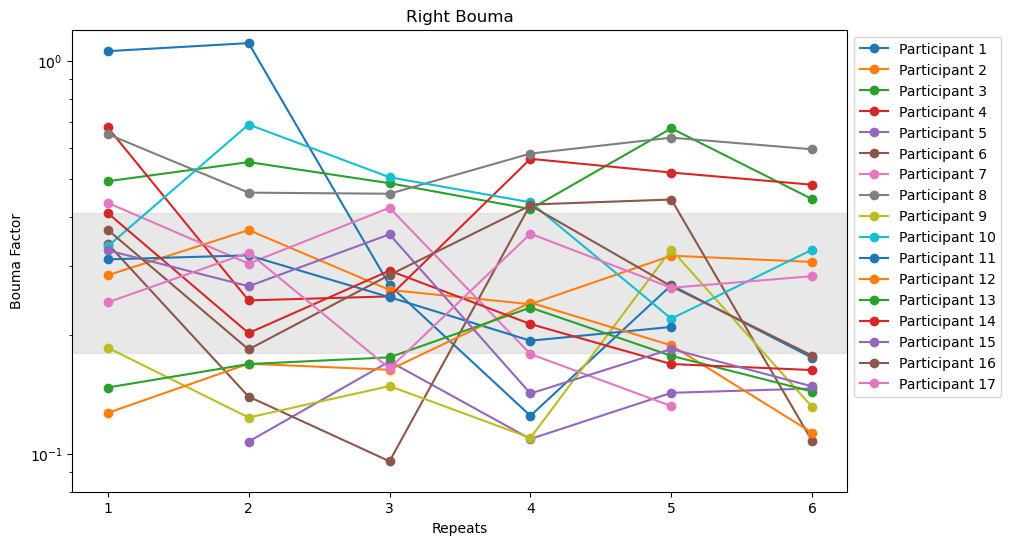

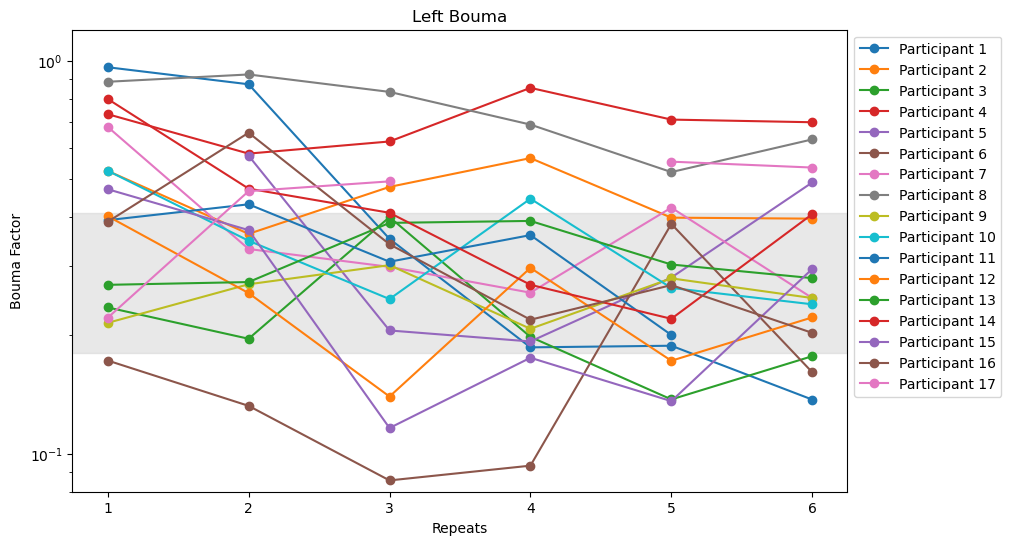

In [10]:
plot_RL_thresholds(subj_left_bouma, subj_right_bouma)

# plot_RL_thresholds(subj_left_effortQ/eccentricity, subj_right_effortQ/eccentricity)

## Left-right asymmetry

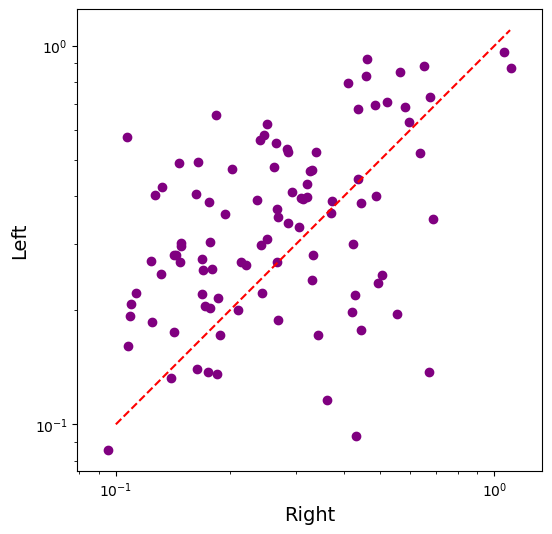

In [11]:
    # Create scatter plot
    plt.figure(figsize=(6, 6))  # Make the plot square
    plt.scatter(subj_right_bouma, subj_left_bouma, color='purple')
    plt.plot([0.1, 1.1], [0.1, 1.1], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')
    # Add labels and legend
    plt.xlabel(f'Right', fontsize = 14)
    plt.ylabel(f'Left', fontsize = 14)

    # Show the plot
    plt.show()

## Average between left and right; take the log
- If we are correlating crowding with other factors like acuity and reading, we will probably average left and right before the analysis.
- Before analyzing data, always take the log.

In [12]:
# exclude participant 2 due to unreliable performance
# filtered_left_bouma = np.delete(subj_left_bouma, 1, axis=0)
# filtered_left_bouma = subj_left

subj_right_logBouma = np.log10(subj_right_bouma)
subj_left_logBouma = np.log10(subj_left_bouma)

subj_avgRL_log = (subj_right_logBouma + subj_left_logBouma) / 2

print(subj_avgRL_log)

[[ 0.00413421 -0.00728954 -0.51212475 -0.81651201 -0.64815803 -0.80922008]
 [-0.41296128 -0.43563006 -0.45208349 -0.43354473 -0.44769393 -0.45688647]
 [-0.46716488 -0.48266863 -0.35465242 -0.54008595 -0.51689743 -0.55200049]
 [-0.15255845 -0.42300654 -0.40246941 -0.15913361 -0.21699607 -0.23587147]
 [        nan -0.60538445 -0.7257787  -0.83851916 -0.69841815 -0.57187073]
 [-0.61425797 -0.86655488 -1.04377018 -0.69817239 -0.38414075 -0.88057577]
 [-0.2648395  -0.49762427 -0.4492615  -0.6683518  -0.62630958         nan]
 [-0.11991416 -0.18513379 -0.20872555 -0.19920893 -0.23939463 -0.21263698]
 [-0.69862997 -0.73843643 -0.67402426 -0.8210083  -0.51707687 -0.74268184]
 [-0.37605997 -0.31003346 -0.45142507 -0.35555083 -0.617292   -0.55017903]
 [-0.45553899 -0.43021973 -0.5565373  -0.57804476 -0.6876525          nan]
 [-0.64589312 -0.68114138 -0.82062064 -0.57128908 -0.74391125 -0.80002882]
 [-0.70093596 -0.66754947 -0.58366013 -0.51787569 -0.63471333 -0.69752895]
 [-0.24232765 -0.50920966

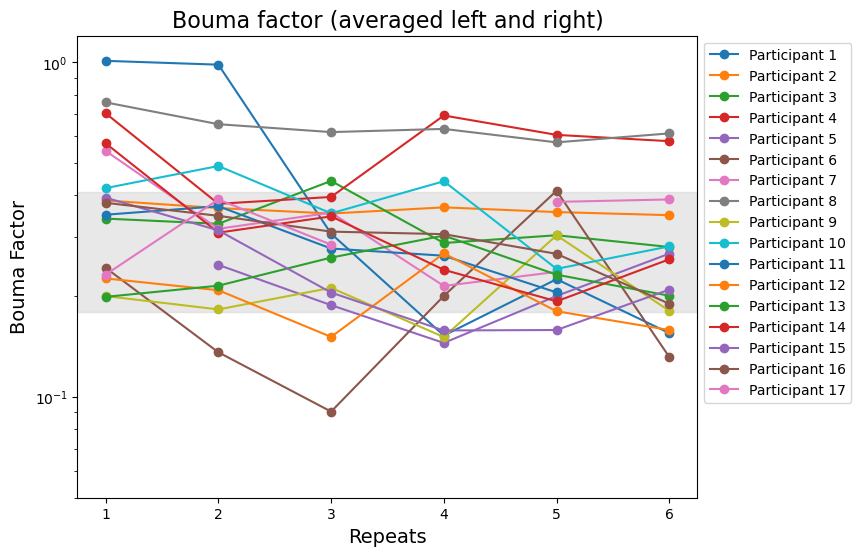

In [13]:
patch_min = 0.18
patch_max = 0.41
repeats = range(1,7)

plt.figure(figsize=(8, 6))
plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
for i, row in enumerate(10 **subj_avgRL_log):
    plt.plot(repeats, row, marker='o', label=f'Participant {i+1}')
plt.title('Bouma factor (averaged left and right)', size=16)
plt.xlabel('Repeats', size=14)
plt.ylabel('Bouma Factor', size=14)
plt.legend()
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim([0.05,1.2])

plt.show()


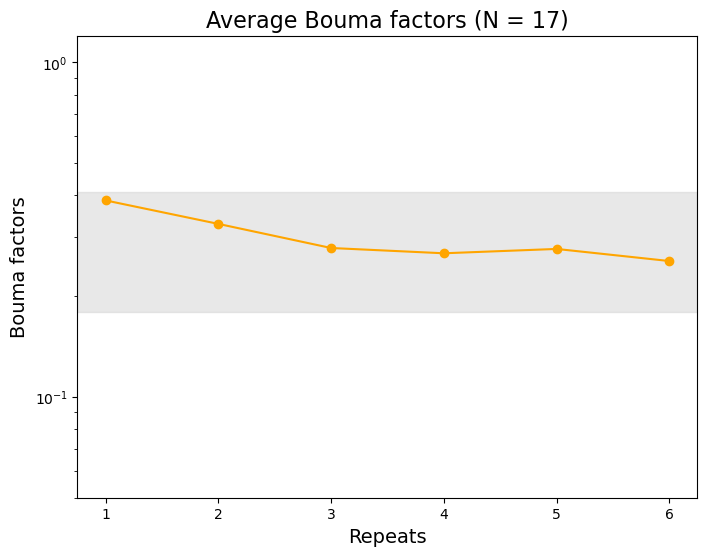

In [14]:
plt.figure(figsize=(8, 6))
patch_min = 0.18
patch_max = 0.41
plt.axhspan(patch_min, patch_max, color='lightgray', alpha=0.5)
plt.plot(range(1,7), 10 ** np.nanmean(subj_avgRL_log, axis = 0), marker='o', color = 'orange')
plt.title(f'Average Bouma factors (N = {numTotalSubj})', fontsize = 16)
plt.xlabel('Repeats', fontsize = 14)
plt.xticks(range(1,7))
plt.ylabel('Bouma factors', fontsize = 14)
plt.yscale('log')
plt.ylim([0.05, 1.2])
# plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()

In [15]:
# print out mean values to show mean learning
print(np.nanmean(subj_avgRL_log, axis = 0))
print(10 ** np.nanmean(subj_avgRL_log, axis = 0))

[-0.41287647 -0.48300611 -0.55499679 -0.57077283 -0.55779905 -0.59392682]
[0.38647689 0.32884701 0.27861417 0.26867495 0.27682222 0.25472594]


### Plot all Bouma factors 
- 6 measurements per participant
- R and L are averaged for each block (measurement)
- if the one of the R or L threshold is excluded (because of exclusion criteria listed in get_threshold()), the measurement will not be plotted (therefore, N for this histogram is smaller than 6 * number of participants)

Min and max bin limits: 0.08, 1.11


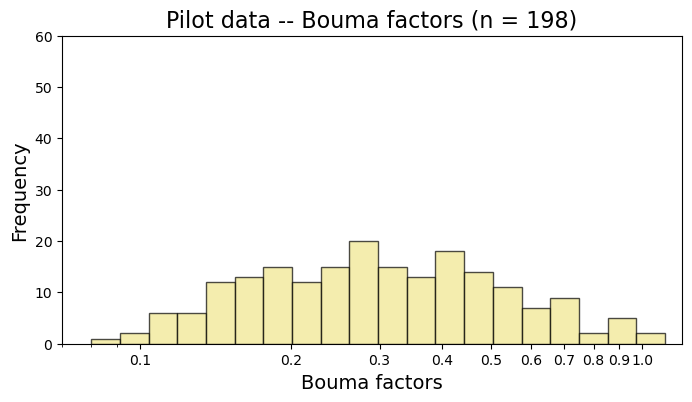

In [16]:
avg_RL_flattened = subj_avgRL_log.flatten()
left_log_flattened = np.log10(subj_left_bouma).flatten()
right_log_flattened = np.log10(subj_right_bouma).flatten()
RL_flattened = np.concatenate([left_log_flattened, right_log_flattened])

# make the bins look the same size on a log scale
num_bins = 20
# min_val = round(10 ** np.nanmin(RL_flattened),2)
# max_val = round(10 ** np.nanmax(RL_flattened),2)
# print(f'Min and max bin limits: {min_val}, {max_val}')
# bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
min_val = 0.08
max_val = 1.11
print(f'Min and max bin limits: {min_val}, {max_val}')
bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)


# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(10 ** RL_flattened, bins=bins, edgecolor='black',color='khaki', alpha=0.7)
plt.xlabel('Bouma factors', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Pilot data -- Bouma factors (n = {len(RL_flattened)-6})', fontsize=16)
plt.xscale('log')
plt.xlim(0.07,1.2)
plt.ylim(0,60)

# add ticks and format them as normal floats
tick_positions = np.linspace(0.1, 1, num=10)  
plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])


plt.show()


## Within- and between-subject standard deviations

Take the variance of the log thresholds, and then square-root to get the standard deviation.

In [17]:
def calculate_within_btw_var(subj_thresholds):
    '''
    Input: subj_thresholds is organized as follows: rows are subjects and columns are repeats
    It is assumed that subj_thresholds contain LOG THRESHOLDS!
    '''

    within_individual_var = np.nanmean(np.nanvar(subj_thresholds, axis=1, ddof=1))


    across_individuals_var = np.nanvar(np.nanmean(subj_thresholds, axis=1), ddof=1)
    

    return within_individual_var, across_individuals_var

def calculate_btw_within_ratio(btw, within):
    '''
    Input: btw and within individual std IN LOG UNITS
    '''
    assert(btw.shape == within.shape)
    
    ratio = (10**btw)/(10**within)
    
    return ratio

In [18]:
within_var_6_repeats, btw_var_6_repeats = calculate_within_btw_var(subj_avgRL_log)
within_std_6_repeats = round(np.sqrt(within_var_6_repeats),2)
btw_std_6_repeats = round(np.sqrt(btw_var_6_repeats),2)

print(f'Within-individual std (across 6 repeats): {within_std_6_repeats}')
print(f'Between-individual std (across 6 repeats): {btw_std_6_repeats}')


_, btw_var_2_repeats = calculate_within_btw_var(subj_avgRL_log[:, 0:2])
btw_std_2_repeats = round(np.sqrt(btw_var_2_repeats),2)

print(f'Between-individual std (across 2 repeats): {btw_std_2_repeats}')


Within-individual std (across 6 repeats): 0.15
Between-individual std (across 6 repeats): 0.15
Between-individual std (across 2 repeats): 0.2


/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_94786/3859917611.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  within_individual_var = np.nanmean(np.nanvar(subj_thresholds, axis=1, ddof=1))


## "Stable" estimates of each threshold

In [19]:
def variance_summary_forward(threshold_mtx, start_block = 3):
    
    numRepeats = threshold_mtx.shape[1]
    numVar = numRepeats - start_block + 1

    
    within_forward = np.full((numVar,1),np.nan)
    btw_forward = np.full((numVar,1),np.nan)
    
    
    for ii in range(start_block,numRepeats+1):

        filtered_data = threshold_mtx[:,:ii]
        
        within_forward[ii-start_block], btw_forward[ii-start_block] = calculate_within_btw_var(filtered_data)
    
    # plot
    repeats = range(start_block, numRepeats+1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(repeats, within_forward, marker='o', label='within-individual variance')
    plt.plot(repeats, btw_forward, marker='o', label='between-individual variance')

    plt.title('within- and between- individual variance: including from first repeat', fontsize = 16)
    plt.xlabel('Repeats including until', fontsize = 14)
    plt.xticks(repeats)
    plt.ylabel('Variance of log Bouma factors', fontsize = 14)
    
    plt.yscale('log')
    ymin = 0.01
    ymax = 0.04
    plt.ylim([ymin, ymax])
    tick_positions = np.linspace(ymin, ymax, num=4)  
    plt.yticks(tick_positions, labels=[f"{x:.2f}" for x in tick_positions])
    plt.gca().tick_params(labelsize=14)

    plt.legend()
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.show()

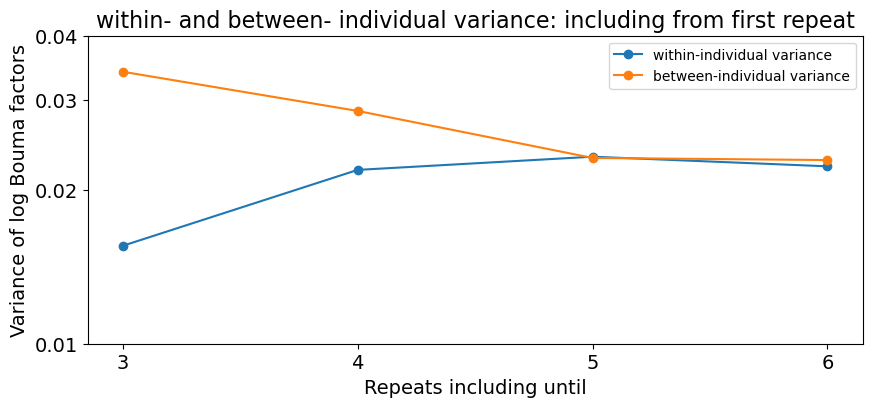

In [20]:
variance_summary_forward(subj_avgRL_log)

More blocks, less noise per subj (will it level off if we had more repeats?)

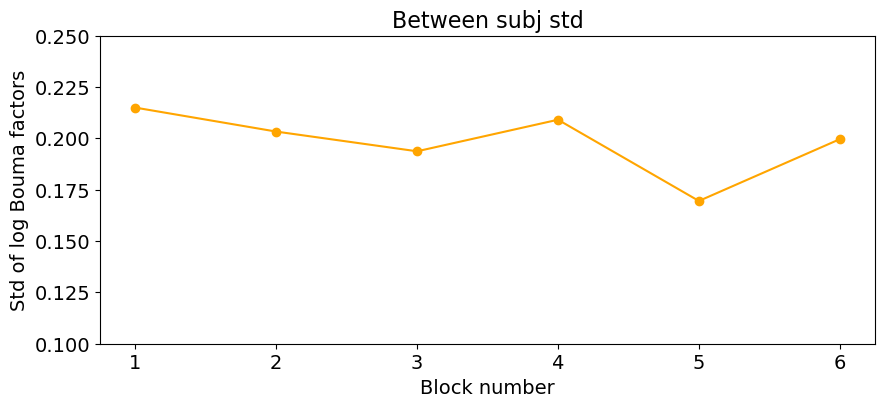

In [21]:
btw_subj_std_across_blocks = np.nanstd(subj_avgRL_log, axis=0, ddof=1)

plt.figure(figsize=(10, 4))
plt.plot(range(1,7), btw_subj_std_across_blocks, marker='o', color = 'orange')
plt.title('Between subj std', fontsize = 16)
plt.xlabel('Block number', fontsize = 14)
plt.xticks(range(1,7))
plt.ylabel('Std of log Bouma factors', fontsize = 14)
plt.ylim(0.1,0.25)
# plt.yscale('log')
# ymin = 0.02
# ymax = 0.06
# plt.ylim([ymin, ymax])
# tick_positions = np.linspace(ymin, ymax, num=4)  
# plt.yticks(tick_positions, labels=[f"{x:.2f}" for x in tick_positions])
plt.gca().tick_params(labelsize=14)
# plt.gca().yaxis.set_major_locator(plt.FixedLocator(tick_positions))  # Remove extra ticks
# plt.gca().yaxis.set_minor_locator(plt.NullLocator())  # Remove minor ticks

# plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.gca().tick_params(labelsize=14)
plt.show()

In [22]:
def variance_summary_backwards(threshold_mtx):
    
    numRepeats = threshold_mtx.shape[1]
    
    within_forward = np.full((numRepeats-2,1),np.nan)
    btw_forward = np.full((numRepeats-2,1),np.nan)

    
    for ii in range(numRepeats-2):

        filtered_data = threshold_mtx[:,ii:]
        
        within_forward[ii], btw_forward[ii] = calculate_within_btw_var(filtered_data)
    
    # plot
    repeats = range(1,numRepeats - 1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(repeats, within_forward, marker='o', label='within-individual variance')
    plt.plot(repeats, btw_forward, marker='o', label='between-individual variance')

    plt.title('within- and between- individual variance: including till the last repeat', fontsize = 16)
    plt.xlabel('Repeats including from', fontsize = 14)
    plt.xticks(repeats)
    plt.ylabel('Variance of log Bouma factors', fontsize = 14)
    plt.legend()
    plt.yscale('log')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.gca().tick_params(labelsize=14)
    plt.show()

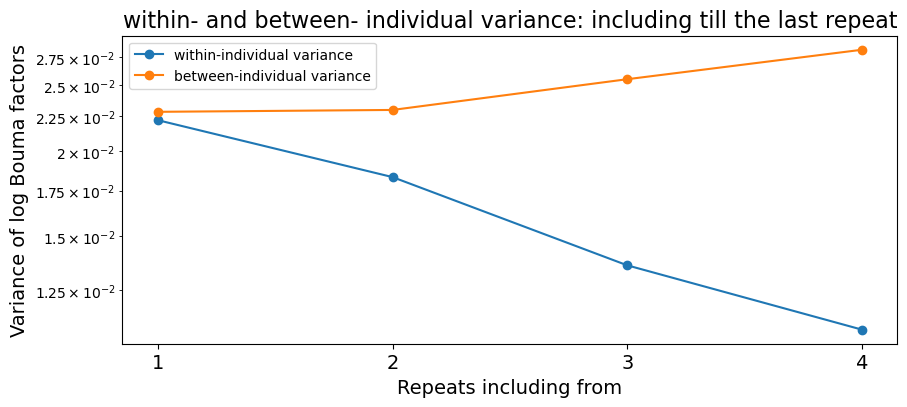

In [23]:
variance_summary_backwards(subj_avgRL_log)


## Average pairs of thresholds

In [24]:
def average_repeats(threshold_mtx, repeat_to_avg):
    '''
    Threshold_mtx contains log thresholds. Rows are subjects. Columns are repeats.
    Repeat_to_avg contains an array of lists. Each list specifies which repeats to average.
    1 should be subtracted from each list in repeat_to_avg before indexing threshold_mtx 
    '''
    
    numDP = len(repeat_to_avg)
    numSubj = threshold_mtx.shape[0]
    
    subj_summarized_log = np.full((numSubj, numDP),np.nan)
    
    for ii in range(numDP):
        
        subj_summarized_log[:,ii] = np.nanmean(threshold_mtx[:,np.array(repeat_to_avg[ii])-1], axis = 1)
    
    return subj_summarized_log

In [25]:
subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,3],[2,4]])
within_4rep_testRetest, btw_4rep_testRetest = calculate_within_btw_var(subj_testRetest_log)
print(f'4 repeats, test-retest \n Within: {within_4rep_testRetest}\n Between: {btw_4rep_testRetest}')

subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,3,5],[2,4,6]])
within_6rep_testRetest, btw_6rep_testRetest = calculate_within_btw_var(subj_testRetest_log)
print(f'6 repeats, test-retest \n Within: {within_6rep_testRetest}\n Between: {btw_6rep_testRetest}')


4 repeats, test-retest 
 Within: 0.006114272479427096
 Between: 0.02850536820138562
6 repeats, test-retest 
 Within: 0.0038745572897103636
 Between: 0.022973827836250075


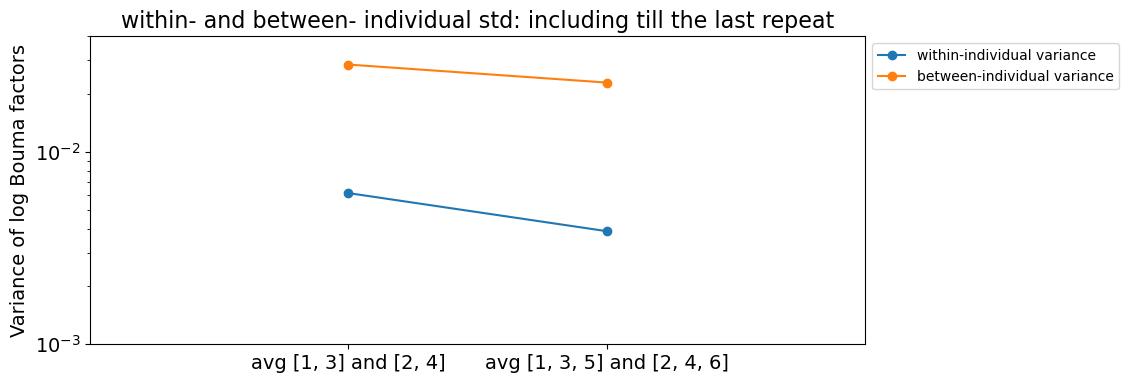

In [26]:
plt.figure(figsize=(10, 4))
plt.plot([1, 2], [within_4rep_testRetest, within_6rep_testRetest], marker='o', label='within-individual variance')
plt.plot([1, 2], [btw_4rep_testRetest, btw_6rep_testRetest], marker='o', label='between-individual variance')

plt.title('within- and between- individual std: including till the last repeat', fontsize = 16)
string_labels = ['avg [1, 3] and [2, 4]', 'avg [1, 3, 5] and [2, 4, 6]']
plt.xticks(ticks=[1, 2], labels=string_labels)
plt.xlim([0, 3])
plt.ylim([0.001, 0.04])
plt.ylabel('Variance of log Bouma factors', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().tick_params(labelsize=14)
plt.show()

In [27]:
subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,2],[3,4]])
within_4rep, btw_4rep = calculate_within_btw_var(subj_testRetest_log)
print(f'4 repeats, test-retest \n Within: {within_4rep}\n Between: {btw_4rep}')

subj_testRetest_log = average_repeats(subj_avgRL_log, [[1,2,3],[4,5,6]])
within_6rep, btw_6rep = calculate_within_btw_var(subj_testRetest_log)
print(f'6 repeats, test-retest \n Within: {within_6rep}\n Between: {btw_6rep}')

4 repeats, test-retest 
 Within: 0.0199733947995607
 Between: 0.027786859212718
6 repeats, test-retest 
 Within: 0.019104373203877065
 Between: 0.022846213859058027


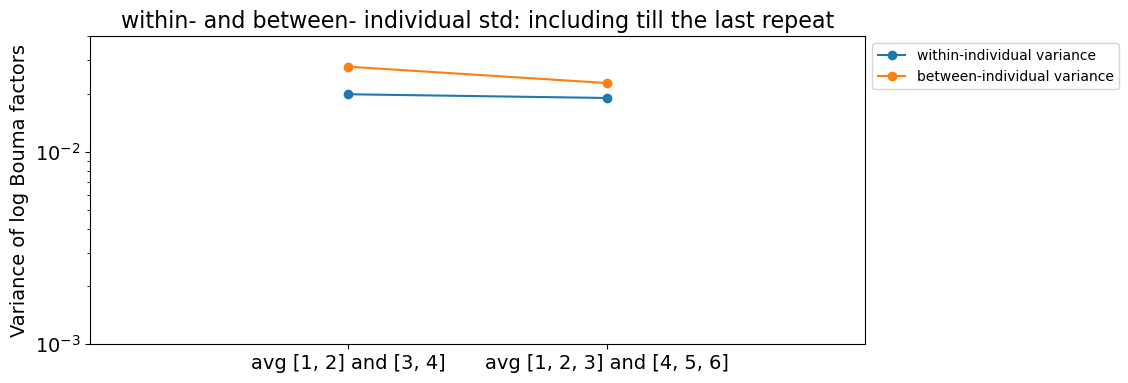

In [28]:
plt.figure(figsize=(10, 4))
plt.plot([1, 2], [within_4rep, within_6rep], marker='o', label='within-individual variance')
plt.plot([1, 2], [btw_4rep, btw_6rep], marker='o', label='between-individual variance')

plt.title('within- and between- individual std: including till the last repeat', fontsize = 16)
string_labels = ['avg [1, 2] and [3, 4]', 'avg [1, 2, 3] and [4, 5, 6]']
plt.xticks(ticks=[1, 2], labels=string_labels)
plt.xlim([0, 3])
plt.ylim([0.001, 0.04])
plt.ylabel('Variance of log Bouma factors', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.gca().tick_params(labelsize=14)
plt.show()

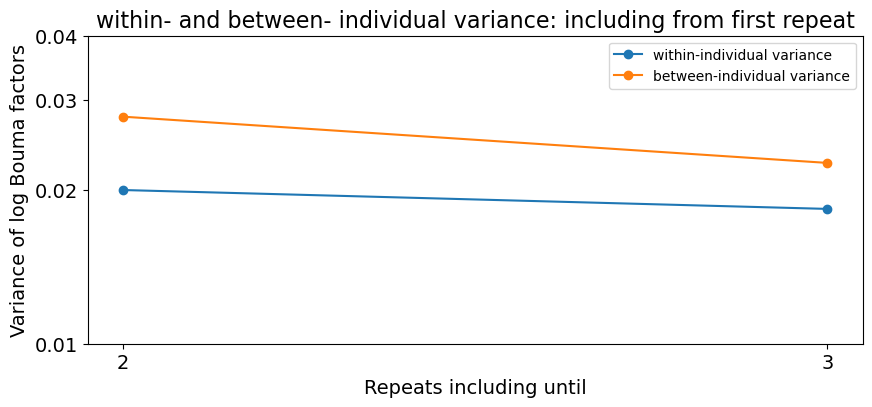

In [29]:
subj_paired_log = average_repeats(subj_avgRL_log, [[1,2],[3,4],[5,6]])

variance_summary_forward(subj_paired_log, start_block = 2)


## Plot test-retest scatter plots

In [30]:
def plot_test_retest_scatter(data, group_X, group_Y):
    '''
    This function filters the data given the provided groupings and plots a scatter plot of test vs. retest
    It can give us an intuition of the within- and between- individual variances
    (i.e., if the within-std is large relative to the btw-std, R is low, and vice versa)
    
    Inputs:
    subj_data:        thresholds for each repeat of each individual. 
                      2D matrix with rows as individuals and columns as repeats.
    group_X, group_Y: specify which repeat(s) (i.e., columns) to include when averaging and plotting
                      for each dimension (X and Y).
                      These two arrays are lists but not np arrays.
    '''
    
    # filter data given the provided groupings
    group_X_array = np.array(group_X)
    group_Y_array = np.array(group_Y)

    data_X = data[:, group_X_array - 1]
    data_Y = data[:, group_Y_array - 1]
    
    
    # calculate one mean for each subject
    means_X = np.nanmean(data_X, axis = 1)
    means_Y = np.nanmean(data_Y, axis = 1)
    
    r_value, _ = pearsonr(means_X, means_Y)
    

    # Create scatter plot
    plt.figure(figsize=(4, 4))  # Make the plot square
    plt.scatter(10 ** means_X, 10 ** means_Y, color='purple', alpha = 0.7)
    plt.plot([0.1, 1.1], [0.1, 1.1], color='red', linestyle='--', label='y = x')  # Line y = x

    # Set axes to have equal scale
    plt.axis('equal')
    plt.xscale('log')
    plt.yscale('log')

    # add ticks and format them as normal floats
    tick_positions = np.linspace(0.1, 1, num=4)  
    plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)
    plt.yticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions], fontsize = 12)

    # Add labels and legend
    plt.xlabel(f'Average over repeats {group_X}', fontsize = 14)
    plt.ylabel(f'Average over repeats {group_Y}', fontsize = 14)
    plt.title(f'Test vs. Retest Correlation (R = {round(r_value,2)})', fontsize = 16)

    # Show the plot
    plt.show()


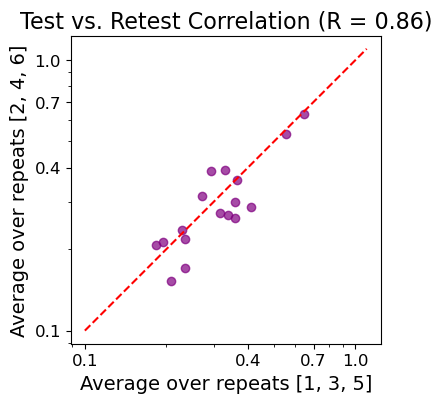

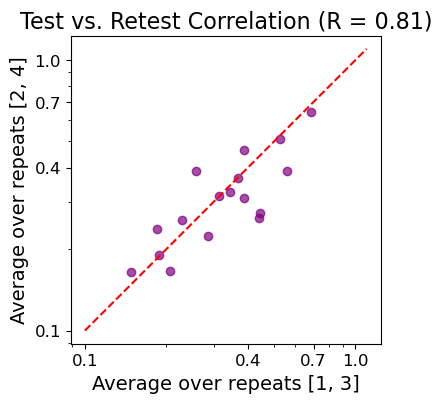

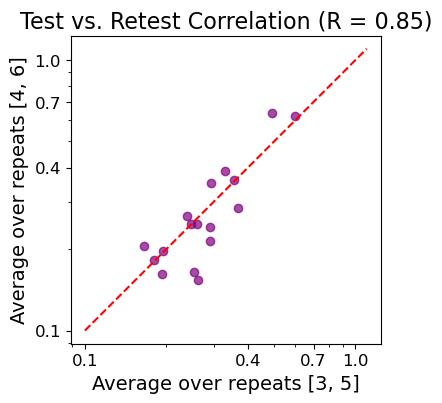

In [31]:
plot_test_retest_scatter(subj_avgRL_log, [1,3,5], [2,4,6])
plot_test_retest_scatter(subj_avgRL_log, [1,3], [2,4])
plot_test_retest_scatter(subj_avgRL_log, [3,5], [4,6])

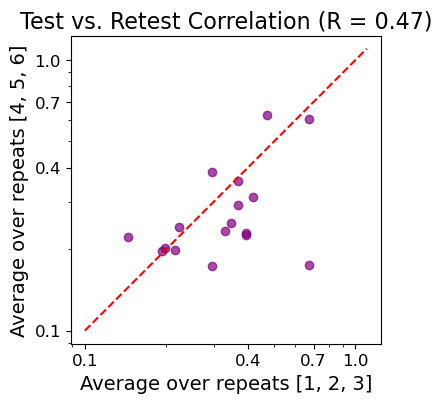

In [32]:
# learning
plot_test_retest_scatter(subj_avgRL_log, [1,2,3], [4,5,6])

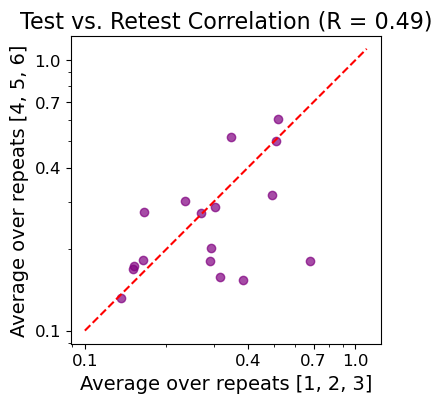

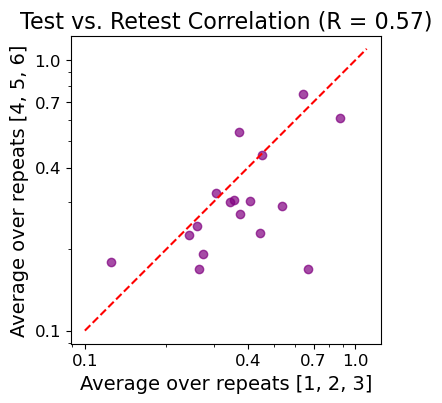

In [33]:
# right bouma factors are more variable than left bouma factors
plot_test_retest_scatter(np.log10(subj_right_bouma), [1,2,3], [4,5,6])
plot_test_retest_scatter(np.log10(subj_left_bouma), [1,2,3], [4,5,6])

## Save unlogged data

In [34]:
subj_avgRL_bouma = 10 ** subj_avgRL_log
print(subj_avgRL_bouma)

[[1.00956483 0.98335528 0.30752133 0.15257662 0.22482364 0.15516005]
 [0.38640142 0.36674985 0.35311528 0.36851509 0.35670243 0.3492316 ]
 [0.3410634  0.32910264 0.44192399 0.28834608 0.30416033 0.28054305]
 [0.7037875  0.3775665  0.39584994 0.69321251 0.60674182 0.58093632]
 [       nan 0.24809359 0.18802747 0.14503768 0.2002543  0.26799659]
 [0.24307597 0.13597063 0.09041278 0.20036765 0.41291366 0.13165102]
 [0.54345113 0.31796237 0.35541725 0.21460913 0.23642338        nan]
 [0.75872752 0.65292939 0.61840707 0.63210768 0.57624261 0.61286246]
 [0.20015665 0.1826264  0.21182428 0.15100513 0.30403468 0.18084985]
 [0.42066853 0.48974108 0.35365103 0.44101075 0.24138374 0.28172213]
 [0.35031683 0.3713473  0.27762764 0.26421365 0.2052804         nan]
 [0.22599919 0.20838124 0.15113998 0.26835576 0.18033862 0.1584788 ]
 [0.19909669 0.21500597 0.26081939 0.30347597 0.23189248 0.20066473]
 [0.57236406 0.30959244 0.3463362  0.23984674 0.19306497 0.25778666]
 [0.39393001 0.31449935 0.20501406

In [35]:
def save_mtx_as_df(matrix, file_path, matrix_name):
    '''
    This function takes in a matrix and its path, and saves it as a data frame in a csv.
    It allows you to customize the name of the file being saved and the folder in which it will be saved.
    
    inputs:
    - matrix: the matrix you're saving
    - file_path: has to be a string: the path to the folder you want the csv to be in
    - matrix_name: has to be a string: the name of the csv file
    '''

    df = pd.DataFrame(matrix)
    file_name = file_path + matrix_name
    df.to_csv(file_name, index=False)

In [36]:
file_path = 'pilot_multiple_repeats_data/thresholds_clean/'
save_mtx_as_df(subj_right_bouma, file_path, 'df_bouma_right.csv')
save_mtx_as_df(subj_left_bouma, file_path, 'df_bouma_left.csv')
save_mtx_as_df(subj_avgRL_bouma, file_path, 'df_bouma_avgRL.csv')